# 2D Latent Diffusion Model

In [1]:
# TODO: Add buttom with "Open with Colab"

## Set up environment using Colab


In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Set up imports

In [3]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import DataLoader, Dataset
from monai.networks.layers import Act
from monai.utils import first, set_determinism
from tqdm import tqdm

from generative.inferers import DiffusionInferer
from generative.losses.adversarial_loss import PatchAdversarialLoss
from generative.losses.perceptual import PerceptualLoss
from generative.networks.nets import AutoencoderKL, DiffusionModelUNet, PatchDiscriminator
from generative.schedulers import DDPMScheduler

print_config()

/home/jdafflon/miniconda3/envs/genmodels/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.1.dev2239
Numpy version: 1.23.4
Pytorch version: 1.13.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 13b24fa92b9d98bd0dc6d5cdcb52504fd09e297b
MONAI __file__: /home/jdafflon/miniconda3/envs/genmodels/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.2.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.14.0
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.4
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: 0.6.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, plea

In [4]:
# for reproducibility purposes set a seed
set_determinism(42)

## Setup a data directory and download dataset
Specify a MONAI_DATA_DIRECTORY variable, where the data will be downloaded. If not specified a temporary directory will be used.

In [5]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpwrotvt10


## Download the training set

In [6]:
train_data = MedNISTDataset(root_dir=root_dir, section="training", download=True, seed=0)
train_datalist = [{"image": item["image"]} for item in train_data.data if item["class_name"] == "Hand"]
image_size = 64
train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        # TODO: Change transformations
        transforms.RandAffined(
            keys=["image"],
            rotate_range=[(-np.pi / 36, np.pi / 36), (-np.pi / 36, np.pi / 36)],
            translate_range=[(-1, 1), (-1, 1)],
            scale_range=[(-0.05, 0.05), (-0.05, 0.05)],
            spatial_size=[image_size, image_size],
            padding_mode="zeros",
            prob=0.5,
        ),
    ]
)
train_ds = Dataset(data=train_datalist, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=4)

MedNIST.tar.gz: 59.0MB [00:00, 71.9MB/s]                                                                                                                                                                                                            

2022-12-02 19:39:54,925 - INFO - Downloaded: /tmp/tmpwrotvt10/MedNIST.tar.gz


2022-12-02 19:39:55,028 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2022-12-02 19:39:55,029 - INFO - Writing into directory: /tmp/tmpwrotvt10.


Loading dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47164/47164 [00:17<00:00, 2628.53it/s]


## Visualise examples from the training set

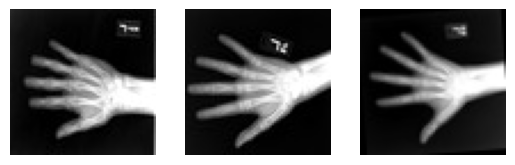

In [7]:
# Plot 3 examples from the training set
check_data = first(train_loader)
fig, ax = plt.subplots(nrows=1, ncols=3)
for image_n in range(3):
    ax[image_n].imshow(check_data["image"][image_n, 0, :, :], cmap="gray")
    ax[image_n].axis("off")

## Download the validation set

In [8]:
val_data = MedNISTDataset(root_dir=root_dir, section="validation", download=True, seed=0)
val_datalist = [{"image": item["image"]} for item in train_data.data if item["class_name"] == "Hand"]
val_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
    ]
)
val_ds = Dataset(data=val_datalist, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=True, num_workers=4)

2022-12-02 19:40:19,157 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2022-12-02 19:40:19,158 - INFO - File exists: /tmp/tmpwrotvt10/MedNIST.tar.gz, skipped downloading.
2022-12-02 19:40:19,159 - INFO - Non-empty folder exists in /tmp/tmpwrotvt10/MedNIST, skipped extracting.


Loading dataset: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5895/5895 [00:02<00:00, 2778.84it/s]


## Define the network

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


In [10]:
autoencoderkl = AutoencoderKL(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_channels=64,
    latent_channels=3,
    ch_mult=(1, 2, 2),
    num_res_blocks=1,
    norm_num_groups=32,
    attention_levels=(False, False, True),
)
autoencoderkl = autoencoderkl.to(device)

In [11]:
unet = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=3,
    out_channels=3,
    num_res_blocks=1,
    num_channels=(128, 256, 256),
    num_head_channels=256,
)

scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_schedule="linear",
    beta_start=0.0015,
    beta_end=0.0195,
)

inferer = DiffusionInferer(scheduler)

discriminator = PatchDiscriminator(
    spatial_dims=2,
    num_layers_d=3,
    num_channels=32,
    in_channels=1,
    out_channels=1,
    kernel_size=4,
    activation=(Act.LEAKYRELU, {"negative_slope": 0.2}),
    norm="BATCH",
    bias=False,
    padding=1,
)
discriminator.to(device)

PatchDiscriminator(
  (initial_conv): Convolution(
    (conv): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (adn): ADN(
      (D): Dropout(p=0.0, inplace=False)
      (A): LeakyReLU(negative_slope=0.2)
    )
  )
  (0): Convolution(
    (conv): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (adn): ADN(
      (N): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (D): Dropout(p=0.0, inplace=False)
      (A): LeakyReLU(negative_slope=0.2)
    )
  )
  (1): Convolution(
    (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (adn): ADN(
      (N): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (D): Dropout(p=0.0, inplace=False)
      (A): LeakyReLU(negative_slope=0.2)
    )
  )
  (2): Convolution(
    (conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (adn): ADN(
      (N): Batch

In [12]:
perceptual_loss = PerceptualLoss(spatial_dims=2, network_type="alex")
perceptual_loss.to(device)
perceptual_weight = 0.001

adv_loss = PatchAdversarialLoss(criterion="least_squares")
adv_weight = 0.01

optimizer_g = torch.optim.Adam(autoencoderkl.parameters(), lr=1e-4)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=5e-4)

/home/jdafflon/miniconda3/envs/genmodels/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jdafflon/miniconda3/envs/genmodels/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
scaler_g = torch.cuda.amp.GradScaler()
scaler_d = torch.cuda.amp.GradScaler()

## Train AutoencoderKL

It takes about ~60 min to train the model.

In [14]:
kl_weight = 1e-6
n_epochs = 100
val_interval = 6
autoencoder_warm_up_n_epochs = 10

epoch_recon_loss_list = []
epoch_gen_loss_list = []
epoch_disc_loss_list = []
val_recon_epoch_loss_list = []
intermediary_images = []
n_example_images = 4

for epoch in range(n_epochs):
    autoencoderkl.train()
    discriminator.train()
    epoch_loss = 0
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=110)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        optimizer_g.zero_grad(set_to_none=True)

        reconstruction, z_mu, z_sigma = autoencoderkl(images)

        recons_loss = F.l1_loss(reconstruction.float(), images.float())
        p_loss = perceptual_loss(reconstruction.float(), images.float())
        kl_loss = 0.5 * torch.sum(z_mu.pow(2) + z_sigma.pow(2) - torch.log(z_sigma.pow(2)) - 1, dim=[1, 2, 3])
        kl_loss = torch.sum(kl_loss) / kl_loss.shape[0]
        loss_g = recons_loss + (kl_weight * kl_loss) + (perceptual_weight * p_loss)

        if epoch > autoencoder_warm_up_n_epochs:
            logits_fake = discriminator(reconstruction.contiguous().float())[-1]
            generator_loss = adv_loss(logits_fake, target_is_real=True, for_discriminator=False)
            loss_g += adv_weight * generator_loss

        loss_g.backward()
        optimizer_g.step()

        if epoch > autoencoder_warm_up_n_epochs:
            optimizer_d.zero_grad(set_to_none=True)

            logits_fake = discriminator(reconstruction.contiguous().detach())[-1]
            loss_d_fake = adv_loss(logits_fake, target_is_real=False, for_discriminator=True)
            logits_real = discriminator(images.contiguous().detach())[-1]
            loss_d_real = adv_loss(logits_real, target_is_real=True, for_discriminator=True)
            discriminator_loss = (loss_d_fake + loss_d_real) * 0.5

            loss_d = adv_weight * discriminator_loss

            loss_d.backward()
            optimizer_d.step()

        epoch_loss += recons_loss.item()
        if epoch > autoencoder_warm_up_n_epochs:
            gen_epoch_loss += generator_loss.item()
            disc_epoch_loss += discriminator_loss.item()

        progress_bar.set_postfix(
            {
                "recons_loss": epoch_loss / (step + 1),
                "gen_loss": gen_epoch_loss / (step + 1),
                "disc_loss": disc_epoch_loss / (step + 1),
            }
        )
    epoch_recon_loss_list.append(epoch_loss / (step + 1))
    epoch_gen_loss_list.append(gen_epoch_loss / (step + 1))
    epoch_disc_loss_list.append(disc_epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        autoencoderkl.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader, start=1):
                images = batch["image"].to(device)
                optimizer_g.zero_grad(set_to_none=True)

                reconstruction, z_mu, z_sigma = autoencoderkl(images)
                # Get the first sammple from the first validation batch for visualisation
                # purposes
                if val_step == 1:
                    intermediary_images.append(reconstruction[:n_example_images, 0])

                recons_loss = F.l1_loss(images.float(), reconstruction.float())

                val_loss += recons_loss.item()

        val_loss /= val_step
        val_recon_epoch_loss_list.append(val_loss)
        print(f"epoch {epoch + 1} val loss: {val_loss:.4f}")
progress_bar.close()


Epoch 5: 100%|█████████████████| 125/125 [00:28<00:00,  4.32it/s, recons_loss=0.0297, gen_loss=0, disc_loss=0]


epoch 6 val loss: 0.0316


Epoch 11: 100%|████████| 125/125 [00:32<00:00,  3.88it/s, recons_loss=0.0226, gen_loss=0.433, disc_loss=0.342]


epoch 12 val loss: 0.0240


Epoch 17: 100%|████████| 125/125 [00:32<00:00,  3.89it/s, recons_loss=0.0209, gen_loss=0.314, disc_loss=0.238]


epoch 18 val loss: 0.0236


Epoch 23: 100%|████████| 125/125 [00:32<00:00,  3.90it/s, recons_loss=0.0204, gen_loss=0.347, disc_loss=0.224]


epoch 24 val loss: 0.0207


Epoch 29: 100%|████████| 125/125 [00:32<00:00,  3.91it/s, recons_loss=0.0182, gen_loss=0.291, disc_loss=0.241]


epoch 30 val loss: 0.0195


Epoch 35: 100%|████████| 125/125 [00:32<00:00,  3.90it/s, recons_loss=0.0175, gen_loss=0.297, disc_loss=0.238]


epoch 36 val loss: 0.0188


Epoch 41: 100%|████████| 125/125 [00:31<00:00,  3.92it/s, recons_loss=0.0173, gen_loss=0.291, disc_loss=0.242]


epoch 42 val loss: 0.0188


Epoch 47: 100%|████████| 125/125 [00:31<00:00,  3.93it/s, recons_loss=0.0167, gen_loss=0.311, disc_loss=0.231]


epoch 48 val loss: 0.0179


Epoch 53: 100%|█████████| 125/125 [00:31<00:00,  3.91it/s, recons_loss=0.0172, gen_loss=0.331, disc_loss=0.23]


epoch 54 val loss: 0.0194


Epoch 59: 100%|██████████| 125/125 [00:31<00:00,  3.92it/s, recons_loss=0.017, gen_loss=0.35, disc_loss=0.223]


epoch 60 val loss: 0.0182


Epoch 65: 100%|█████████| 125/125 [00:31<00:00,  3.92it/s, recons_loss=0.017, gen_loss=0.368, disc_loss=0.214]


epoch 66 val loss: 0.0195


Epoch 71: 100%|████████| 125/125 [00:32<00:00,  3.90it/s, recons_loss=0.0177, gen_loss=0.394, disc_loss=0.207]


epoch 72 val loss: 0.0191


Epoch 77: 100%|████████| 125/125 [00:31<00:00,  3.91it/s, recons_loss=0.0181, gen_loss=0.422, disc_loss=0.196]


epoch 78 val loss: 0.0213


Epoch 83: 100%|████████| 125/125 [00:31<00:00,  3.91it/s, recons_loss=0.0183, gen_loss=0.494, disc_loss=0.174]


epoch 84 val loss: 0.0222


Epoch 89: 100%|████████| 125/125 [00:31<00:00,  3.92it/s, recons_loss=0.0183, gen_loss=0.508, disc_loss=0.167]


epoch 90 val loss: 0.0207


Epoch 95: 100%|████████| 125/125 [00:32<00:00,  3.90it/s, recons_loss=0.0187, gen_loss=0.501, disc_loss=0.176]


epoch 96 val loss: 0.0199


Epoch 99: 100%|████████| 125/125 [00:31<00:00,  3.91it/s, recons_loss=0.0185, gen_loss=0.545, disc_loss=0.152]


### Visualise the results from the autoencoderKL

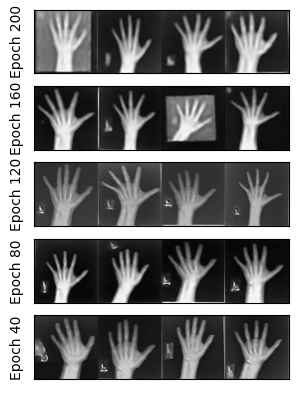

In [22]:
# Plot last 5 evaluations
val_samples = np.linspace(n_epochs, val_interval, int(n_epochs / val_interval))
fig, ax = plt.subplots(nrows=5, ncols=1, sharey=True)
for image_n in range(5):
    reconstructions = torch.reshape(intermediary_images[image_n], (image_size * n_example_images, image_size)).T
    ax[image_n].imshow(reconstructions.cpu(), cmap="gray")
    ax[image_n].set_xticks([])
    ax[image_n].set_yticks([])
    ax[image_n].set_ylabel(f"Epoch {val_samples[image_n]:.0f}")

## Train Diffusion Model

It takes about ~80 min to train the model.

Epoch 39: 100%|████████| 125/125 [00:23<00:00,  5.35it/s, loss=0.0696]


Epoch 39 val loss: 0.0619


100%|████████████████████████████| 1000/1000 [00:08<00:00, 120.94it/s]


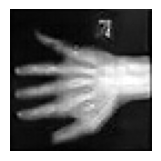

Epoch 79: 100%|████████| 125/125 [00:23<00:00,  5.36it/s, loss=0.0634]


Epoch 79 val loss: 0.0583


100%|████████████████████████████| 1000/1000 [00:08<00:00, 121.24it/s]


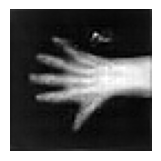

Epoch 119: 100%|███████| 125/125 [00:23<00:00,  5.33it/s, loss=0.0627]


Epoch 119 val loss: 0.0567


100%|████████████████████████████| 1000/1000 [00:08<00:00, 121.15it/s]


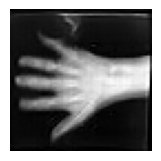

Epoch 159: 100%|███████| 125/125 [00:23<00:00,  5.33it/s, loss=0.0592]


Epoch 159 val loss: 0.0543


100%|████████████████████████████| 1000/1000 [00:08<00:00, 120.88it/s]


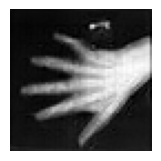

Epoch 199: 100%|███████| 125/125 [00:23<00:00,  5.34it/s, loss=0.0593]


Epoch 199 val loss: 0.0549


100%|████████████████████████████| 1000/1000 [00:08<00:00, 121.06it/s]


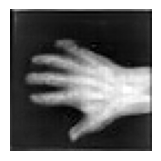

In [16]:
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-4)

unet = unet.to(device)
n_epochs = 200
val_interval = 40
epoch_loss_list = []
val_epoch_loss_list = []

for epoch in range(n_epochs):
    unet.train()
    autoencoderkl.eval()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        optimizer.zero_grad(set_to_none=True)

        z_mu, z_sigma = autoencoderkl.encode(images)
        z = autoencoderkl.sampling(z_mu, z_sigma)

        noise = torch.randn_like(z).to(device)
        noise_pred = inferer(inputs=z, diffusion_model=unet, noise=noise)
        loss = F.mse_loss(noise_pred.float(), noise.float())

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        progress_bar.set_postfix(
            {
                "loss": epoch_loss / (step + 1),
            }
        )
    epoch_loss_list.append(epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        unet.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader, start=1):
                images = batch["image"].to(device)
                optimizer.zero_grad(set_to_none=True)

                z_mu, z_sigma = autoencoderkl.encode(images)
                z = autoencoderkl.sampling(z_mu, z_sigma)

                noise = torch.randn_like(z).to(device)
                noise_pred = inferer(inputs=z, diffusion_model=unet, noise=noise)

                loss = F.mse_loss(noise_pred.float(), noise.float())

                val_loss += loss.item()
        val_loss /= val_step
        val_epoch_loss_list.append(val_loss)
        print(f"Epoch {epoch} val loss: {val_loss:.4f}")

        # Sampling image during training
        z = torch.randn((1, 3, 16, 16))
        z = z.to(device)
        scheduler.set_timesteps(num_inference_steps=1000)
        for t in tqdm(scheduler.timesteps, ncols=70):
            # 1. predict noise model_output
            with torch.no_grad():
                model_output = unet(z, torch.Tensor((t,)).to(device))

                # 2. compute previous image: x_t -> x_t-1
                z, _ = scheduler.step(model_output, t, z)

        with torch.no_grad():
            decoded = autoencoderkl.decode(z)
        plt.figure(figsize=(2, 2))
        plt.style.use("default")
        plt.imshow(decoded[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
        plt.tight_layout()
        plt.axis("off")
        plt.show()
progress_bar.close()


### Plotting sampling example

In [17]:
unet.eval()
image = torch.randn((1, 1, 64, 64))
image = image.to(device)
scheduler.set_timesteps(num_inference_steps=1000)

with torch.no_grad():

    z_mu, z_sigma = autoencoderkl.encode(image)
    z = autoencoderkl.sampling(z_mu, z_sigma)

    noise = torch.randn_like(z).to(device)
    image, intermediates = inferer.sample(
        input_noise=z, diffusion_model=unet, scheduler=scheduler, save_intermediates=True, intermediate_steps=100
    )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 120.73it/s]


(-0.5, 639.5, 63.5, -0.5)

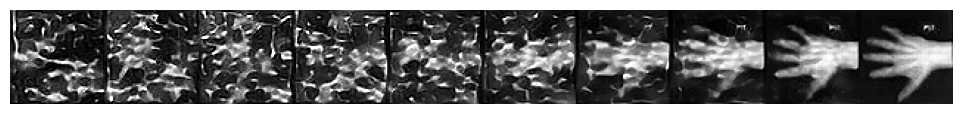

In [18]:
# Invert the autoencoderKL model
decoded_images = []
for image in intermediates:
    with torch.no_grad():
        decoded = autoencoderkl.decode(image)
        decoded_images.append(decoded)
plt.figure(figsize=(10, 12))
chain = torch.cat(decoded_images, dim=-1)
plt.style.use("default")
plt.imshow(chain[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")

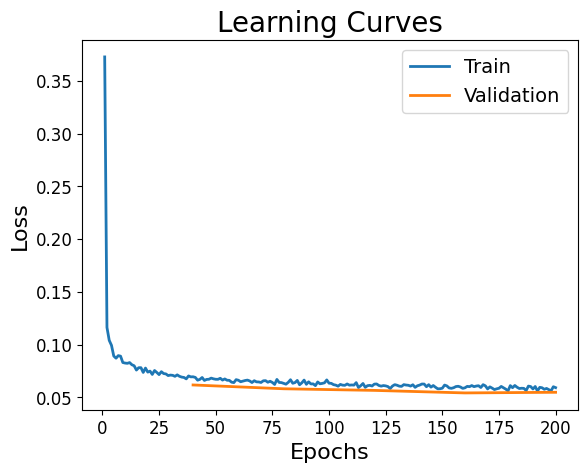

In [19]:
# ## Plot learning curves
plt.figure()
plt.title("Learning Curves", fontsize=20)
plt.plot(np.linspace(1, n_epochs, n_epochs), epoch_loss_list, linewidth=2.0, label="Train")
plt.plot(
    np.linspace(val_interval, n_epochs, int(n_epochs / val_interval)),
    val_epoch_loss_list,
    linewidth=2.0,
    label="Validation",
)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})

In [20]:
### Clean-up data directory

In [21]:
if directory is None:
    shutil.rmtree(root_dir)